### Data Inspector, Cacher
In this document we will read in our data set:
* read in all our audio data, train and test
* merge train and tests datasets
* inspect the diversity of the audio data
* normalize the data and save as a cached npy file


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import helper
import os
import math 

# reproducibility
np.random.seed(42)

### Dataset Read In
In this section we will read in our data set structure which is located in our home holder

```
root:
    kaggle_2018_dataset:
        train:
            wav files for training only, contains catalog.csv
        test:
            wav files for testing our model, contains catalog.csv
        data:
            npy files, feature extraction MFCC and MEL-SPEC
        models:
            trained models
```

In [2]:
# get the data set root directory path
dataset_root_dir = os.path.join("/home/charlesedwards/Documents", 'kaggle_2018_dataset')

# get the train and test data directories
train_dir = os.path.join(dataset_root_dir, 'train')
test_dir = os.path.join(dataset_root_dir, 'test')

# get the catalog.csv for train and test directories
train_catalog_csv = os.path.join(train_dir, 'catalog.csv')
test_catalog_csv = os.path.join(test_dir, 'catalog.csv')

# read the catalog.csv files
train_metadata = pd.read_csv(train_catalog_csv)
test_metadata = pd.read_csv(test_catalog_csv)

# drop unwanted columns 
train_metadata.drop(['license','freesound_id'], axis=1, inplace=True)
test_metadata.drop(['license','freesound_id'], axis=1, inplace=True)

# display the first 5 rows of both metadatas
helper.display_side_by_side([train_metadata.head(),test_metadata.head()], ['train_metadata', 'test_metadata'])

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1
,fname,label,usage
0,00326aa9.wav,Oboe,Private
1,0038a046.wav,Bass_drum,Private
2,007759c4.wav,Saxophone,Private
3,008afd93.wav,Saxophone,Private


In [3]:
print(len(train_metadata.index))
# merge train_metadata and test_metadata
metadata = pd.concat([train_metadata, test_metadata])
print(len(metadata.index))
metadata.head()

9473
11073


,fname,label,manually_verified,usage
0,00044347.wav,Hi-hat,0.0,NaN
1,001ca53d.wav,Saxophone,1.0,NaN
2,002d256b.wav,Trumpet,0.0,NaN
3,0033e230.wav,Glockenspiel,1.0,NaN
4,00353774.wav,Cello,1.0,NaN


### Visualize Label Distribution 
In this section of the notebook we will display the label distribution i.e number of audio files per class

Minimum samples per category =  120
Maximum samples per category =  410


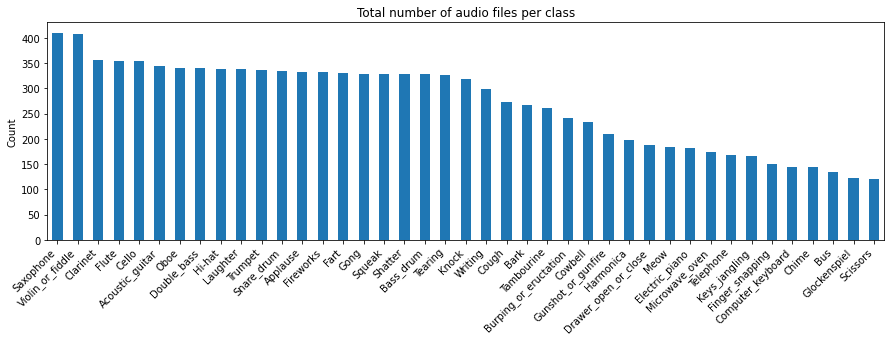

In [4]:
# # visualize the label count distribution
# plt.figure(figsize=(15,4))
# chart = train_metadata['label'].value_counts().plot(kind='bar',)
# chart.set_xticklabels(labels=chart.get_xticklabels(), rotation=45, horizontalalignment='right')
# chart.set_title("Total number of audio files per class")
# chart.set_ylabel('Count')

# print('Minimum samples per category = ', min(train_metadata['label'].value_counts()))
# print('Maximum samples per category = ', max(train_metadata['label'].value_counts()))

# visualize the label count distribution
plt.figure(figsize=(15,4))
chart = metadata['label'].value_counts().plot(kind='bar',)
chart.set_xticklabels(labels=chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_title("Total number of audio files per class")
chart.set_ylabel('Count')

print('Minimum samples per category = ', min(metadata['label'].value_counts()))
print('Maximum samples per category = ', max(metadata['label'].value_counts()))

### Visualize Verified Label Distribution 
In this section of the notebook we will display how many labels are verified vs not

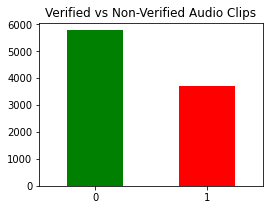

In [5]:
plt.figure(figsize=(4,3))

# plot the number of manually_verified vs non manually_verified audio clips
verified_count = train_metadata['manually_verified'].value_counts()
verified_count.plot(kind='bar', color=['green', 'red'], rot=0, title='Verified vs Non-Verified Audio Clips')


### Read Audio To Memory
This process will take a lot of ram and may vary on dataset size. Atm a 5GB dataset uses roughly 12GB of ram

In [6]:
# Windowing
n_fft=1024
hop_length=512
DELTA_TIME = 1

def load_data_set(data_dir="TEST AND TRAIN MERGED",metadata_pd=None, sample_rate=44100 ):

    processed_samples_data = []
    labels = []

    print(f"Processing audio from: {data_dir} ... with {len(metadata_pd)} files\nn_fft: {n_fft}\nhop_length: {hop_length}")

    length = len(metadata_pd)
    counter = 0

    # using librosa for every fname in our data_frame generate a mel spectrogram and save it to a numpy array
    for x, row in enumerate(metadata_pd.iloc):
        
        target_file = ""
        # detect if row["usage"] is NaN
        #print(str(row["usage"]).lower())
        if str(row["usage"]).lower() == "nan":
            # if nan its a test train
            target_file = os.path.join( train_dir, row['fname'] )
        else:
            target_file = os.path.join( test_dir, row['fname'] )

        # load the audio file
        #y, sr = librosa.load( target_file, sr=sample_rate, duration=max_duration, mono=True )

        # this function will downsample and monofy the audio file if necessary
        # returns normalized Y and sample rate
        sr, y = helper.downsample_mono(target_file, sample_rate)

        delta_sample = int(DELTA_TIME*sample_rate)

        # cleaned audio is less than a single sample
        #wav pad with zeros to delta_sample size
        if y.shape[0] < delta_sample:
            sample = np.zeros(shape=(delta_sample,), dtype=np.float32) # np.int16
            sample[:y.shape[0]] = y
            # append the data to our processed_samples_data array
            processed_samples_data.append(sample)
            labels.append(row['label'])
        # step through audio and save every delta_sample
        # discard the ending audio if it is too short
        else:
            trunc = y.shape[0] % delta_sample
            for cnt, i in enumerate(np.arange(0, y.shape[0]-trunc, delta_sample)):
                start = int(i)
                stop = int(i + delta_sample)
                sample = y[start:stop]

                # append the data to our processed_samples_data array
                processed_samples_data.append(sample)
                labels.append(row['label'])

        # Notify update every N files
        if (counter == 500):
            print("Status: {}/{}".format(x+1, length))
            counter = 0

        counter += 1


    print("done")

    print( "saving cached padded dataset" )

    # NOTE: we are saving audio data more than what we have i.e we are padding the audio data and creating additional features to the dataset
    # Convert features (X) and labels (y) to Numpy arrays
    X = np.array(processed_samples_data) # this will contain our normalized audio data of floats between -1 and 1
    y = np.array(labels) # labels for each audio file

    data_npy_folder = os.path.join(dataset_root_dir, 'data')

    # Optionally save the features to disk
    base_name = "normalized_audio_data"
    np.save( os.path.join(data_npy_folder, f"X-{base_name}" ), X)
    np.save( os.path.join(data_npy_folder, f"y-{base_name}" ), y)

    print( "done" )


In [7]:
# # load in the train data set
# load_data_set(train_dir, train_metadata, max_duration=None)

# # load in the test data set
# load_data_set(test_dir, test_metadata, max_duration=None)

load_data_set(metadata_pd=metadata)

Processing audio from: TEST AND TRAIN MERGED ... with 11073 files
n_fft: 1024
hop_length: 512
Status: 501/11073
Status: 1001/11073
Status: 1501/11073
Status: 2001/11073
Status: 2501/11073
Status: 3001/11073
Status: 3501/11073
Status: 4001/11073
Status: 4501/11073
Status: 5001/11073
Status: 5501/11073
Status: 6001/11073
Status: 6501/11073
Status: 7001/11073
Status: 7501/11073
Status: 8001/11073
Status: 8501/11073
Status: 9001/11073
Status: 9501/11073
Status: 10001/11073
Status: 10501/11073
Status: 11001/11073
done
saving cached padded dataset
done
